In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Any, NamedTuple, Callable

from Ecosystem.types import Ecosystem
from Ecosystem.temp import setup
from Ecosystem.utils import mult_by_layer, default_ecosystem, set_random, set_scale, animate
from Ecosystem.operations import calc_energy, get_neighbors
# from Ecosystem.simulators import grow

import json

np.set_printoptions(suppress=True)

In [3]:
def grow(
  system: Ecosystem, 
  plants: pd.DataFrame
) -> Ecosystem:
  
  res, spc, ene = system.resource, system.species, system.energy
  rel = plants.filter(regex='p')
  
  N = spc
  K_ene = res + mult_by_layer(N, plants.e)
  K_ene[K_ene.round(4) == 0] = 1e-4
  K_num = mult_by_layer(K_ene, 1/plants.e)

  # Logistic Function w/ plant interaction ... plant.rのhetelogeneity | fraction(?) ... 同じ状況で経過するとneg e.g. 自分でやられるアレロパシー
  interaction = np.array([mult_by_layer(N, rel.iloc[i]).sum(axis=0) for i in range(len(spc))])
  mask = np.ones_like(spc)
  mask[spc==0] = 0
  interaction *= mask
  logistic = mult_by_layer(N * (1 - (N - interaction) / K_num), plants.r)
  
  n_spc = N + logistic
  n_spc[n_spc<1e-4] = 0
  n_res = ene - calc_energy(n_spc, plants)
  
  return Ecosystem(n_res, n_spc, ene)

def seed(
  system: Ecosystem, 
  plants: pd.DataFrame,
  distance: int = 1,
) -> Ecosystem:
  res, spc, ene = system.resource, system.species, system.energy
  z, y, x = spc.shape
  seeds = get_neighbors(spc, distance)
  
  n_spc = spc.copy() + mult_by_layer(seeds, plants.g)
  n_res = ene - calc_energy(n_spc, plants)
  return Ecosystem(n_res, n_spc, ene)

def harvest(
  system: Ecosystem,
  plants: pd.DataFrame,
  n_intervention: int
) -> Ecosystem:
  res, spc, ene = system.resource, system.species, system.energy
  n_spc = spc.copy()
  n_res = np.zeros_like(res)
  human = (1 - 0.3 * np.random.rand())
  
  # Regularize by resource capacity
  idx = res < 0
  coef = np.ones_like(res)
  coef[idx] = (ene / (-res[idx] + ene))
  n_spc *= human * coef
  
  # Human Intervention ... harvest(種) + stamping(硬さparams ... 水の利用料/germintion変わる etc...)(セル毎)
  # 収穫の最大化 / 早めにとって再成長を狙うなど / 競合する種を抜く ... 空間的に非対称を入れるか(interaction) / 時間的な非対称性
  rate = spc.sum(1).sum(1)
  rate = (rate / rate.sum()).cumsum()
  spc_inter = [np.argmax(rate > i) for i in np.random.rand(n_intervention)]
  n_spc[spc_inter, :, :] *= human
  
  # Stamping
#   z, y, x = spc.shape
#   rand_pos_x = np.random.randint(0, x, n_intervention)
#   rand_pos_y = np.random.randint(0, y, n_intervention)
#   n_spc[:, rand_pos_y, rand_pos_x] *= 0.1
  
  n_res = ene - calc_energy(n_spc, plants)
  return Ecosystem(n_res, n_spc, ene)

def plant(
  system: Ecosystem,
  plants: pd.DataFrame
):
  pass

def mask(system: Ecosystem, plants: pd.DataFrame, masking: np.ndarray) -> Ecosystem:
  res, spc, ene = system.resource, system.species, system.energy
  
  n_spc = spc.copy()
  n_spc *= masking
  
  n_res = ene - calc_energy(spc, plants)
  
  return Ecosystem(n_res, n_spc, ene)

# Case 1: Plants located on the edges

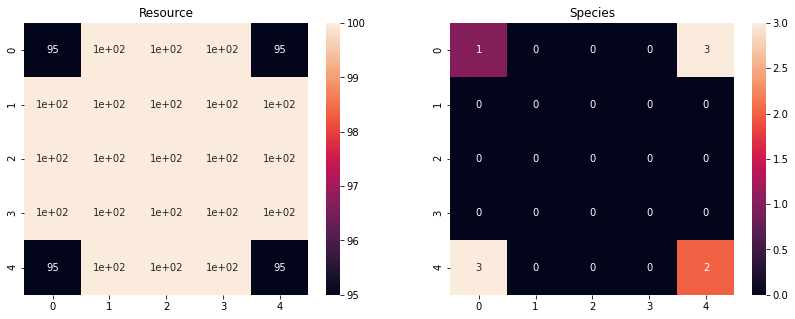

In [41]:
system, plants = setup("./Ecosystem/plants.csv")
res, spc, ene = system.resource, system.species, system.energy

system = Ecosystem(90+res, spc, 100)
system.heatmap()

<AxesSubplot:>

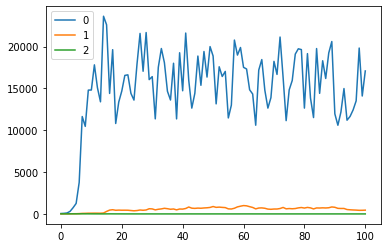

In [42]:
buffer = [system]

for i in range(100):
  system = grow(system, plants)
  system = seed(system, plants)  
  system = harvest(system, plants, 1)
  buffer.append(system)

result = pd.DataFrame([[b.species.sum(1).sum(1)[i] for b in buffer] for i in range(3)]).T
result.plot()

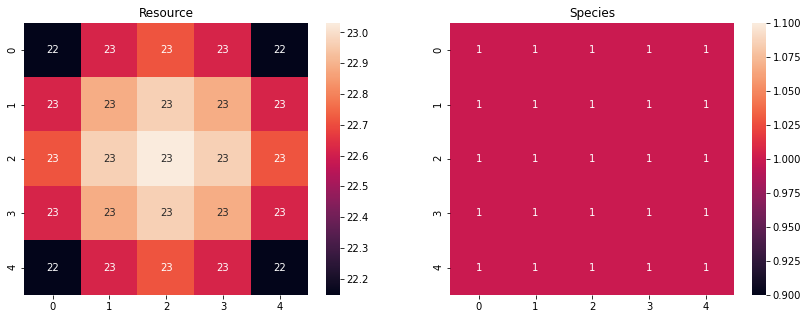

In [43]:
buffer[100].heatmap()

# Case2: plants located on the same position

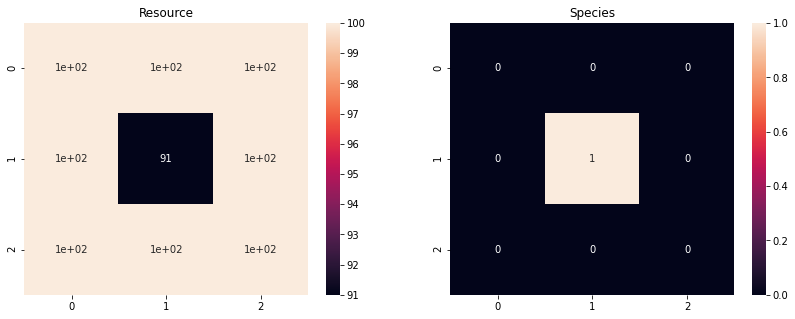

In [6]:
sys = default_ecosystem((3,3), 3, 100)
p = pd.read_csv('./Ecosystem/plants.csv')
r, s, e = sys.resource, sys.species, sys.energy

s[0][1,1] = 30
s[1][1,1] = 6
s[2][1,1] = 3

r = e - calc_energy(s, p)

sys = Ecosystem(r, s, e)
sys.heatmap()

<AxesSubplot:>

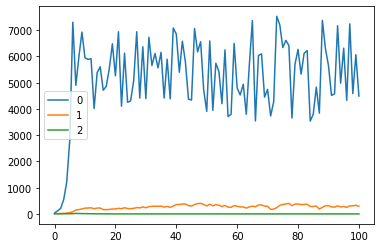

In [7]:
b = [sys]
for i in range(100):
  sys = grow(sys, p)
  sys = seed(sys, p)
  sys = harvest(sys, p)
  b.append(sys)

result = pd.DataFrame([[_b.species.sum(1).sum(1)[i] for _b in b] for i in range(3)]).T
result.plot()

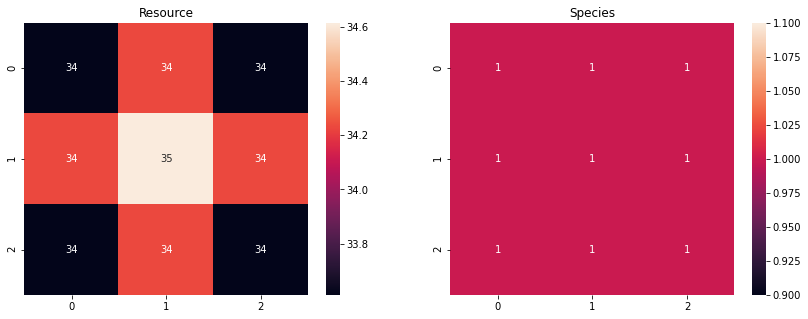

In [8]:
b[100].heatmap()

# 100 spec with random

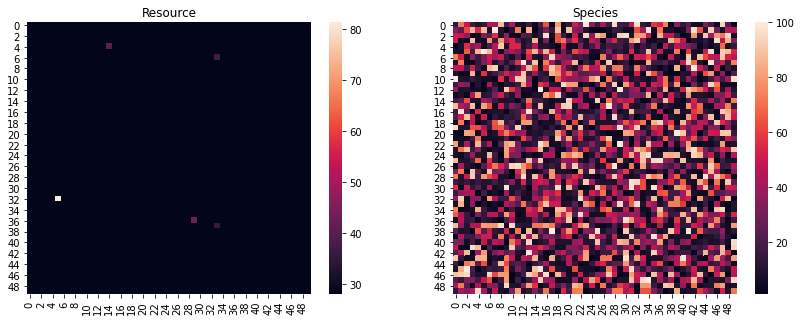

In [3]:
p = pd.read_csv('./Ecosystem/p_temp.csv', index_col=0)

system = default_ecosystem((50, 50), 100, 100)
res, spc, ene = system.resource, system.species, system.energy

spc = set_scale(spc, p, 250, 100)
res = ene - calc_energy(spc, p)

system = harvest(Ecosystem(res, spc, ene), p, 0)

system.heatmap(False)

<AxesSubplot:>

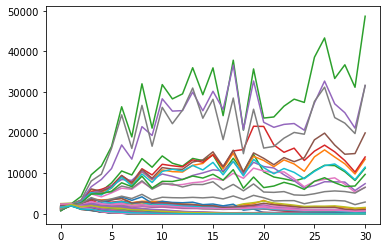

In [4]:
b = [system]
for i in range(30):
  system = grow(system, p)
  system = seed(system, p)
  system = harvest(system, p, 20)
  b.append(system)

result = pd.DataFrame(
  [[_b.species.sum(1).sum(1)[i] for _b in b] for i in range(len(system.species))],
  index = [f"p_{i}" for i in range(len(system.species))]
).T

result.plot(legend=None)

<AxesSubplot:>

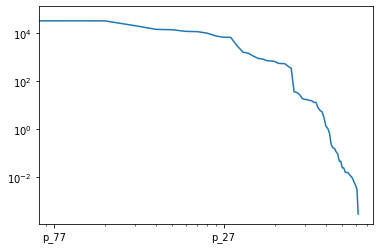

In [5]:
temp = result.iloc[-1]
temp[temp>0].sort_values(ascending=False).plot(logx=True, logy=True)

In [6]:
temp.sort_values(ascending=False).head(30).index

Index(['p_42', 'p_77', 'p_74', 'p_25', 'p_23', 'p_21', 'p_59', 'p_12', 'p_82',
       'p_24', 'p_27', 'p_26', 'p_97', 'p_28', 'p_11', 'p_75', 'p_6', 'p_66',
       'p_76', 'p_33', 'p_54', 'p_34', 'p_69', 'p_67', 'p_60', 'p_3', 'p_64',
       'p_61', 'p_15', 'p_37'],
      dtype='object')

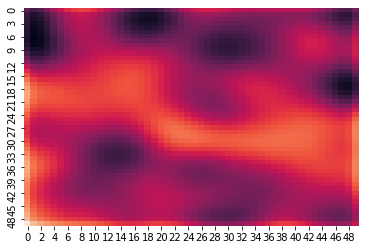

In [7]:
animate([e.species[21] for e in b], 'animate.gif')

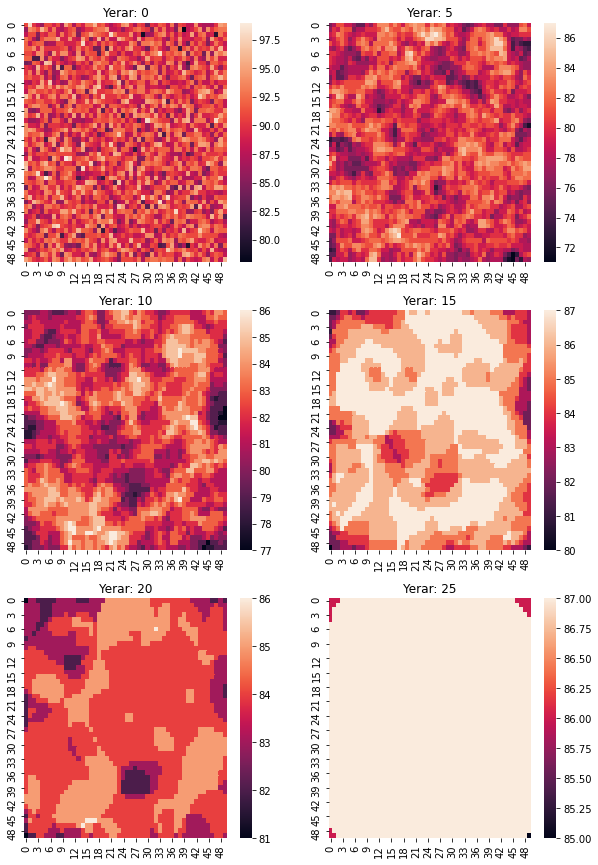

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for idx, i in enumerate(range(0, 30, 5)):
  last = b[i]

  lspc = last.species.copy()

  threshold = lspc<1
  lspc[threshold] = 1
  lspc[~threshold] = 0

  sns.heatmap(lspc.sum(0), ax=ax[idx//2, idx%2])
  ax[idx//2, idx%2].set_title(f"Yerar: {i}")

fig.savefig('species_mini.png')

# Case4: Mono

In [99]:
p = pd.read_csv('./Ecosystem/100spec.csv', index_col=0)

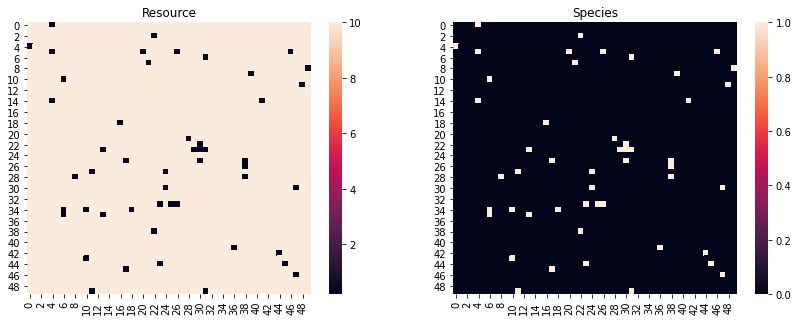

In [101]:
system = default_ecosystem((50, 50), 1, 10)
res, spc, ene = system.resource, system.species, system.energy

spc = set_random(spc, 50)
res = ene - calc_energy(spc, p_temp)

system = harvest(Ecosystem(res, spc, ene), p_temp, 0)

system.heatmap(False)

In [103]:
b = [system]
for i in range(30):
  system = grow(system, p)
  system = seed(system, p)
  system = harvest(system, p, 0)
  b.append(system)

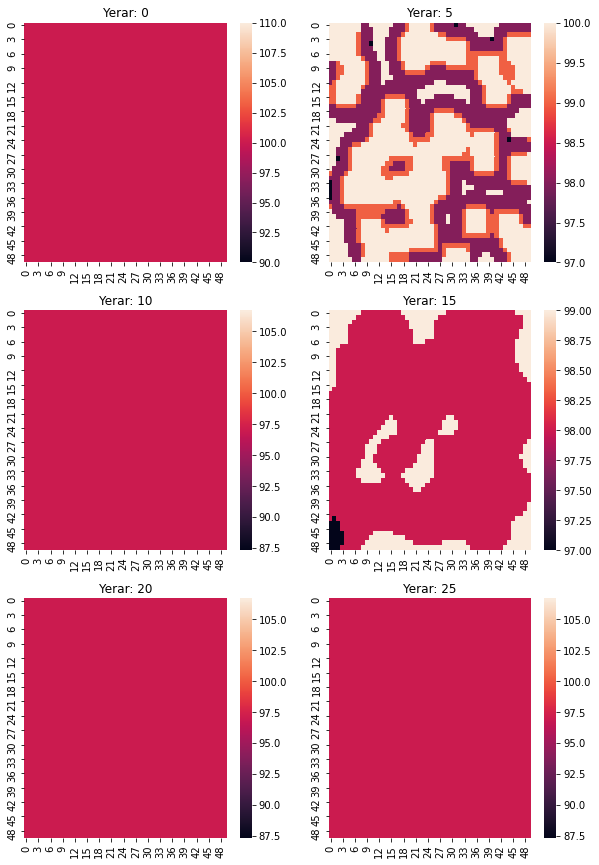

In [106]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for idx, i in enumerate(range(0, 30, 5)):
  last = b[i]

  lspc = last.species.copy()

  threshold = lspc<1
  lspc[threshold] = 1
  lspc[~threshold] = 0

  sns.heatmap(lspc.sum(0), ax=ax[idx//2, idx%2])
  ax[idx//2, idx%2].set_title(f"Yerar: {i}")

# Roppongi

In [3]:
with open('./resource/roppongi2045.json', 'r')as f:
  product = json.load(f)

In [8]:
geogrid = np.array([annot[i['name']] for i in product['GEOGRIDDATA']])[::-1].reshape(50, 50)
masking = np.array([type_weight.loc[i['name']] for i in product['GEOGRIDDATA']])[::-1].reshape(50, 50)

Text(0.5, 1.0, 'Propergation Rate')

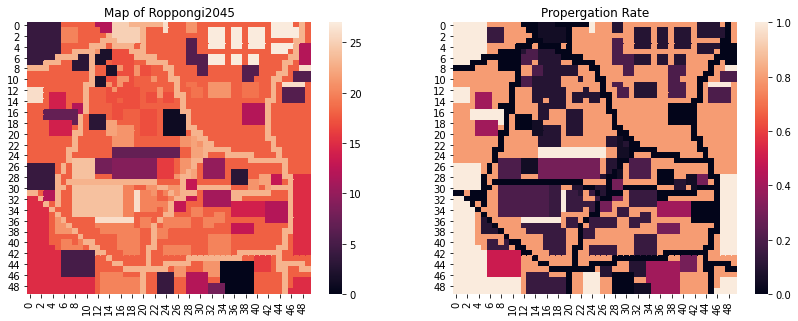

In [9]:
fig, axis = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(geogrid, ax=axis[0])
axis[0].set_title('Map of Roppongi2045')
sns.heatmap(masking, ax=axis[1])
axis[1].set_title('Propergation Rate')

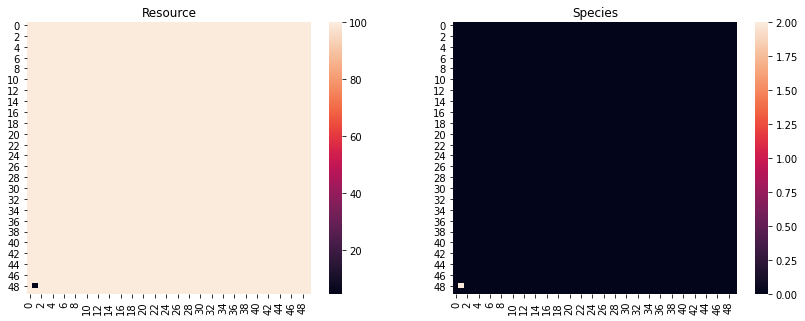

In [28]:
roppongi = default_ecosystem((50,50), 100, 100)
p = pd.read_csv('./Ecosystem/p_temp.csv', index_col=0)

res, spc, ene = roppongi.resource, roppongi.species, roppongi.energy

# spc = set_scale(spc, p, 250, 100)
spc = spc.copy()
spc[:, 48,1] = ((1 / p.r) * 25)
spc *= masking
res = ene - calc_energy(spc, p)

roppongi = harvest(Ecosystem(res, spc, ene), p, 0)
roppongi.heatmap(False)

In [29]:
b = [roppongi]
for i in range(150):
  roppongi = grow(roppongi, p)
  roppongi = seed(roppongi, p)
  roppongi = mask(roppongi, p, masking)
  roppongi = harvest(roppongi, p, 20)
  b.append(roppongi)

<AxesSubplot:>

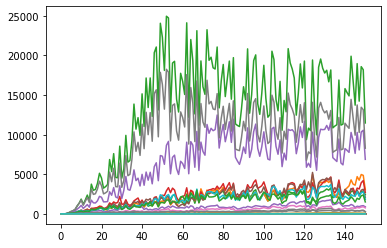

In [30]:
result = pd.DataFrame(
  [[_b.species.sum(1).sum(1)[i] for _b in b] for i in range(len(roppongi.species))],
  index = [f"p_{i}" for i in range(len(roppongi.species))]
).T

result.plot(legend=None)

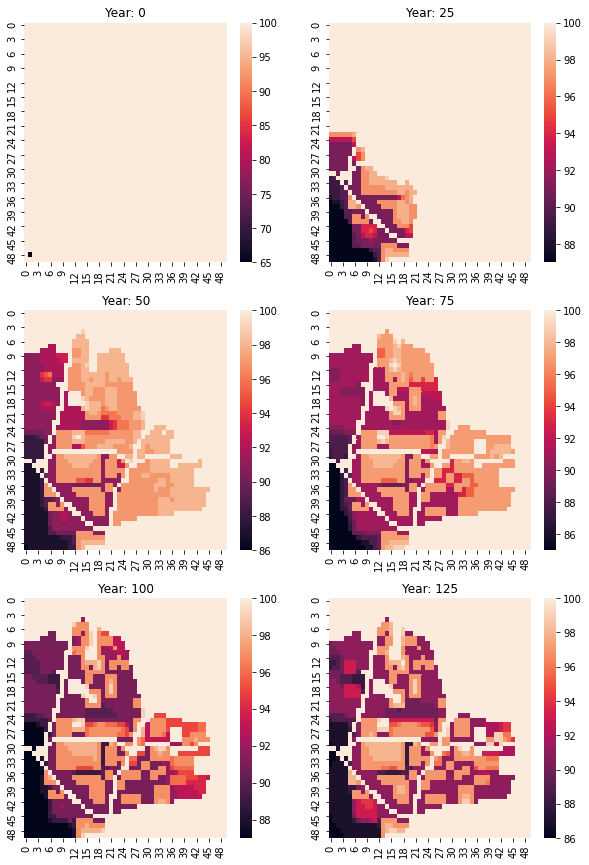

In [39]:
heatmap = []
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for idx, i in enumerate(range(0, 150, 25)):
  last = b[i]

  lspc = last.species.copy()

  threshold = lspc<1
  lspc[threshold] = 1
  lspc[~threshold] = 0
  
  heatmap.append(lspc.sum(0))
  sns.heatmap(lspc.sum(0), ax=ax[idx//2, idx%2])
  ax[idx//2, idx%2].set_title(f"Year: {i}")

fig.savefig('species_mini.png')

In [40]:
result.iloc[29].sort_values(ascending=False).head(10)

p_42    8554.091528
p_77    6417.309001
p_74    3557.507786
p_23    2211.682004
p_25    1422.238091
p_21    1243.695715
p_82    1055.321721
p_59     954.830651
p_12     787.700202
p_24     684.155832
Name: 29, dtype: float64

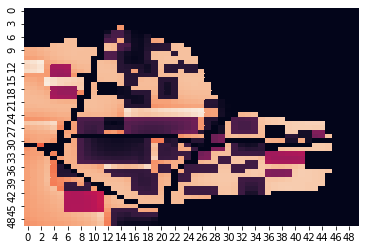

In [41]:
animate([e.species[74] for e in b], './results/animate.gif')

In [24]:
heatmap = []
for idx, i in enumerate(range(0, 30)):
  last = b[i]

  lspc = last.species.copy()

  threshold = lspc<1
  lspc[threshold] = 1
  lspc[~threshold] = 0
  
  heatmap.append(mult_by_layer(lspc, p.K).sum(0))

In [452]:
with open('./results/heatmap.json', 'w') as f:
  json.dump([i.flatten().tolist() for i in heatmap], f)

# Umekita

In [64]:
with open('./resource/umekitaRailway.json', 'r')as f:
  product = json.load(f)

In [65]:
annot = {k:i for i, k in enumerate(product['GEOGRID']['properties']['types'].keys())}
type_weight = pd.read_csv('./resource/type_weight.csv', index_col=0)

In [66]:
type_weight.loc['RailLine'] = 1
type_weight.loc['Station'] = 0.25
type_weight.loc['Office'] = 0.25

In [67]:
geogrid = np.array([annot[i['name']] for i in product['GEOGRIDDATA']])[::-1].reshape(60, 60)
masking = np.array([type_weight.loc[i['name']] for i in product['GEOGRIDDATA']])[::-1].reshape(60, 60)

Text(0.5, 1.0, 'Propergation Rate')

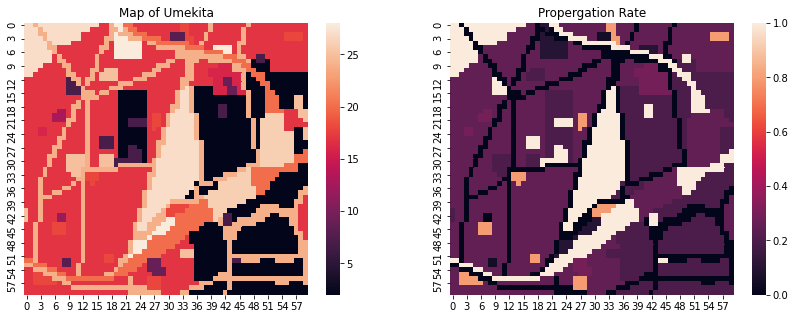

In [68]:
fig, axis = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(geogrid, ax=axis[0])
axis[0].set_title('Map of Umekita')
sns.heatmap(masking, ax=axis[1])
axis[1].set_title('Propergation Rate')

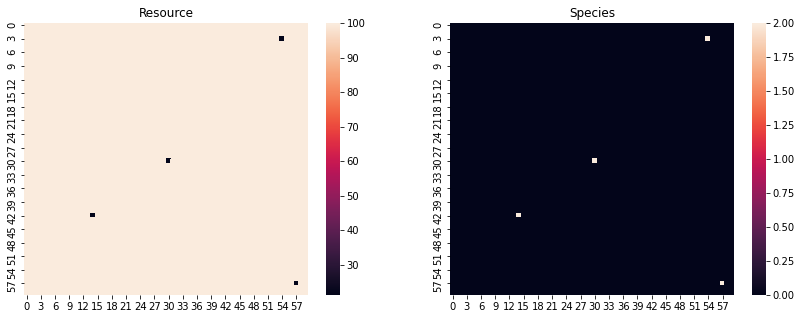

In [69]:
umekita = default_ecosystem((60, 60), 100, 100)
p = pd.read_csv('./Ecosystem/p_temp.csv', index_col=0)

res, spc, ene = umekita.resource, umekita.species, umekita.energy

# spc = set_scale(spc, p, 250, 100)
spc = spc.copy()
spc[:, 30,30] = ((1 / p.r) * 25)
spc[:, 42,14] = ((1 / p.r) * 25)
spc[:, 3,54] = ((1 / p.r) * 25)
spc[:, 57,57] = ((1 / p.r) * 25)
spc *= masking
res = ene - calc_energy(spc, p)

umekita = harvest(Ecosystem(res, spc, ene), p, 0)
umekita.heatmap(False)

<AxesSubplot:>

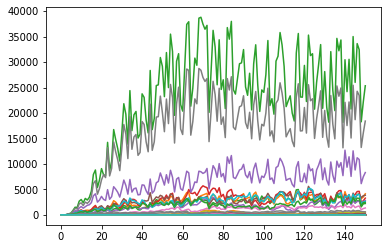

In [70]:
city = umekita

b = [city]
for i in range(150):
  city = grow(city, p)
  city = seed(city, p)
  city = mask(city, p, masking)
  city = harvest(city, p, 20)
  b.append(city)

result = pd.DataFrame(
  [[_b.species.sum(1).sum(1)[i] for _b in b] for i in range(len(city.species))],
  index = [f"p_{i}" for i in range(len(city.species))]
).T

result.plot(legend=None)

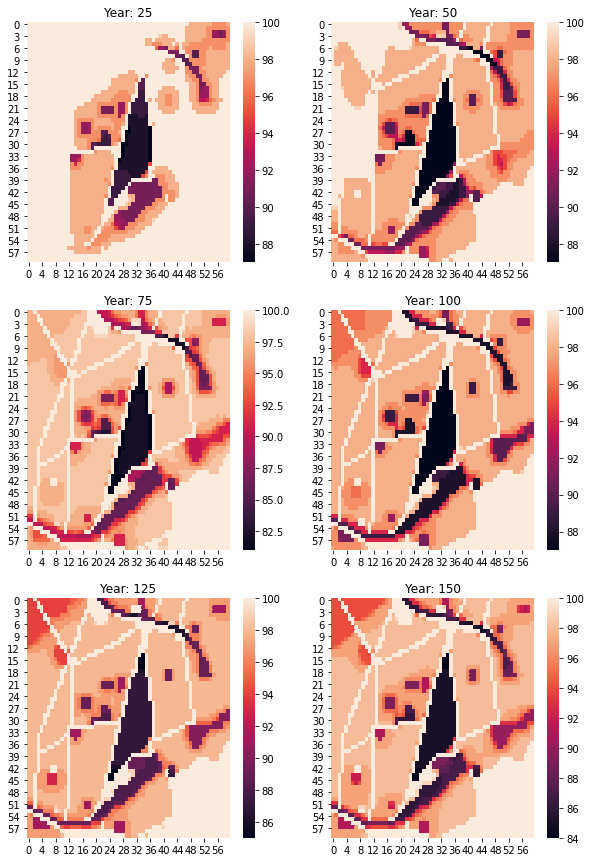

In [71]:
heatmap = []
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for idx, i in enumerate(range(25, 151, 25)):
  last = b[i]

  lspc = last.species.copy()

  threshold = lspc<1
  lspc[threshold] = 1
  lspc[~threshold] = 0
  
  heatmap.append(lspc.sum(0))
  sns.heatmap(lspc.sum(0), ax=ax[idx//2, idx%2])
  ax[idx//2, idx%2].set_title(f"Year: {i}")

fig.savefig('./results/n_species.png')

In [72]:
ranking = result.iloc[29].sort_values(ascending=False)
ranking[ranking!=0].head(10)

p_42    10558.694494
p_77     8694.297863
p_74     3502.461616
p_25     1762.629225
p_59     1736.146293
p_21     1454.412108
p_23     1337.229693
p_12     1112.556934
p_82      934.209790
p_24      840.625451
Name: 29, dtype: float64

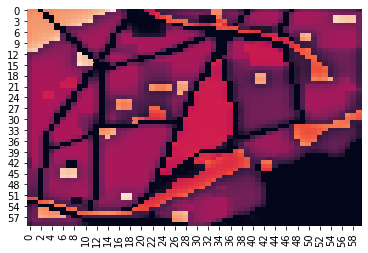

In [73]:
animate([e.species[42] for e in b], './results/animate.gif')

In [18]:
heatmap = []
for idx, i in enumerate(range(0, 30)):
  last = b[i]

  lspc = last.species.copy()

  threshold = lspc<1
  lspc[threshold] = 1
  lspc[~threshold] = 0
  
  heatmap.append(mult_by_layer(lspc, p.K).sum(0))

In [19]:
with open('./results/heatmap.json', 'w') as f:
  json.dump([i.flatten().tolist() for i in heatmap], f)